## Part 2: Implement a PyTorch-based Solution 

### Importing Libraries

In [27]:
import torch 
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
loss = torch.nn.L1Loss()


In [3]:
cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
x = torch.tensor([1., 2.], device=cuda0)
# x.device is device(type='cuda', index=0)
y = torch.tensor([1., 2.]).cuda()


We will do the following steps in order:


1.   Load and normalize the CIFAR10 training and test datasets using torchvision
2.   Define a Convolutional Neural Network.
3.   Define a loss function, Train the network on the training data
4.   Test the network on the test data

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Load and normalize the CIFAR10 training and test datasets using torchvision.

In [29]:
def AugData(change):
    # Data transformations
    transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    if(change == True):
      transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ,transforms.RandomHorizontalFlip()
        ])
    return transform



In [4]:
def loadtraindata(batchsize):
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform= AugData(True))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                              shuffle=True, num_workers=2)
  return trainloader
  
def loadtestdata(batchsize):
  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform= AugData(False))
  testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                              shuffle=False, num_workers=2)
  return testloader

### 2. Define a Convolutional Neural Network.

In [5]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(22*22*64, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Accuracy function

In [6]:
def Accuracy(loaddata,input):     
    correct = 0
    total = 0
    for data in loaddata:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = input(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total


def Lloss(loaddata,input):  
    criterion = nn.CrossEntropyLoss() 
    loss = 0.0
    total = 0
    for data in loaddata:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = input(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        l = criterion(outputs, labels)
        loss += l.item()
    return loss / total


In [7]:
def graphAcc(TrainAcc,TestAcc,Epoch):
  x = Epoch
  plt.plot(x,TrainAcc,color='green',linestyle = 'dotted', label = 'Training Accuracy') 
  plt.plot(x,TestAcc,color='blue',label= 'Testing Accuracy')
  plt.legend()
  plt.show()

def graphLoss(TrainLoss,TestLoss,Epoch):
  x = Epoch
  plt.plot(x,TrainLoss,color='green', label = 'Training Loss') 
  plt.plot(x,TestLoss,color='blue',label= 'Testing Loss')
  plt.legend()
  plt.show()



3. Define a Loss function and optimizer and Train.

CNN

We will give batch size, epochs and learning rate as inputs

In [30]:
class CNNModel:
  def __init__(self, batch_size,epochs,lr):
    self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    self.batchSize = batch_size
    self.epochs = epochs
    self.learningRate = lr
    self.trainloader = None
    self.valLoader = None
    self.AccTrain = []
    self.AccVal = []
    self.Epoch = []
    self.LossTrain = []
    self.LossVal = []
    self.Model = None


    self.trainloader = loadtraindata(self.batchSize)
    self.valLoader = loadtestdata(self.batchSize)


  def train(self):
    batches = 50000/self.batchSize
    Train_Acc=[]
    Test_Acc=[]
    Train_Loss=[]
    Test_Loss=[]
    Epochs=[]
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    criterion2 = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=self.learningRate)

    for epoch in range(self.epochs):  
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          valr = nn.functional.log_softmax(outputs,dim =1)
          loss = criterion2(valr, labels)
          bcloss = nn.HingeEmbeddingLoss()
          # Backpropagation and optimization
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          # if i % 4000 == 3999:    # print every 2000 mini-batches
      print(f' Epoch: {epoch + 1} loss: {running_loss / batches:.3f}')
      running_loss = 0.0
      with torch.no_grad():
        testAcc = Accuracy(self.valLoader,model)
        trainAcc = Accuracy(self.trainloader, model)
        Train_Acc.append(trainAcc)
        Test_Acc.append(testAcc)
        testLoss = Lloss(self.valLoader,model)
        trainLoss = Lloss(self.trainloader, model)
        Train_Loss.append(trainLoss)
        Test_Loss.append(testLoss)
        Epochs.append(epoch+1)
    self.Model = model
    self.AccVal = Test_Acc
    self.AccTrain = Train_Acc
    self.LossTest = Test_Loss
    self.LossTrain = Train_Loss
    self.Epoch = Epochs






## Learning Rate (LR)

Learning Rate (LR): Use initial LR of 0.001. Use two other LR values according to your judgement and report your observations on the training and validation loss curves. Also discuss the effect on class-wise accuracy. You may use a suitable number of epochs and any batch size.

In [9]:
def class_validation(M):
  correct_pred = {classname: 0 for classname in M.classes}
  total_pred = {classname: 0 for classname in M.classes}
  trainingEpoch_loss = []
  validationEpoch_loss = []
  # again no gradients needed
  with torch.no_grad():
      for data in M.valLoader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[M.classes[label]] += 1
              total_pred[M.classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')



Learning rate = 0.01

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.505
 Epoch: 2 loss: 1.090
 Epoch: 3 loss: 0.916
 Epoch: 4 loss: 0.810
 Epoch: 5 loss: 0.730
 Epoch: 6 loss: 0.660
 Epoch: 7 loss: 0.605
 Epoch: 8 loss: 0.555
 Epoch: 9 loss: 0.503
 Epoch: 10 loss: 0.458
 Epoch: 11 loss: 0.416
 Epoch: 12 loss: 0.381
 Epoch: 13 loss: 0.336
 Epoch: 14 loss: 0.305
 Epoch: 15 loss: 0.283
---------(lr = 0.01 )----------


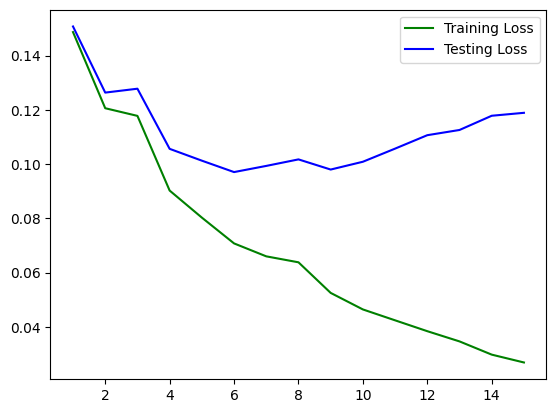

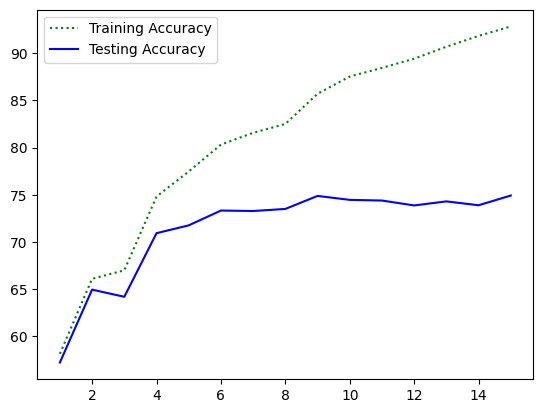

Accuracy for class: plane is 76.5 %
Accuracy for class: car   is 85.9 %
Accuracy for class: bird  is 70.7 %
Accuracy for class: cat   is 53.6 %
Accuracy for class: deer  is 77.2 %
Accuracy for class: dog   is 67.1 %
Accuracy for class: frog  is 78.3 %
Accuracy for class: horse is 75.6 %
Accuracy for class: ship  is 81.0 %
Accuracy for class: truck is 83.3 %


In [ ]:
with torch.cuda.device(0):
  
  lrate = 0.01
  M = CNNModel(8,15,lrate)
  transform = AugData(True)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)


Learning rate = 0.001

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.910
 Epoch: 2 loss: 1.495
 Epoch: 3 loss: 1.348
 Epoch: 4 loss: 1.251
 Epoch: 5 loss: 1.167
 Epoch: 6 loss: 1.089
 Epoch: 7 loss: 1.021
 Epoch: 8 loss: 0.962
 Epoch: 9 loss: 0.911
 Epoch: 10 loss: 0.872
 Epoch: 11 loss: 0.832
 Epoch: 12 loss: 0.795
 Epoch: 13 loss: 0.760
 Epoch: 14 loss: 0.727
 Epoch: 15 loss: 0.698
---------(lr = 0.001 )----------


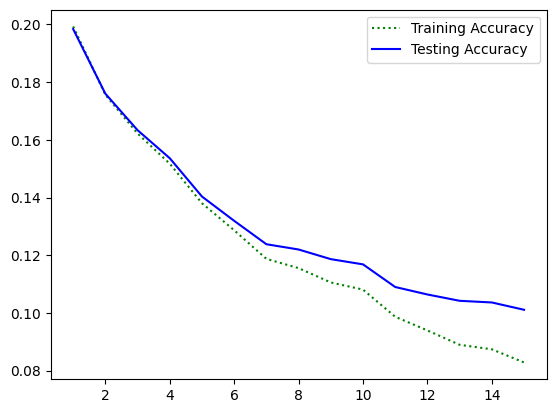

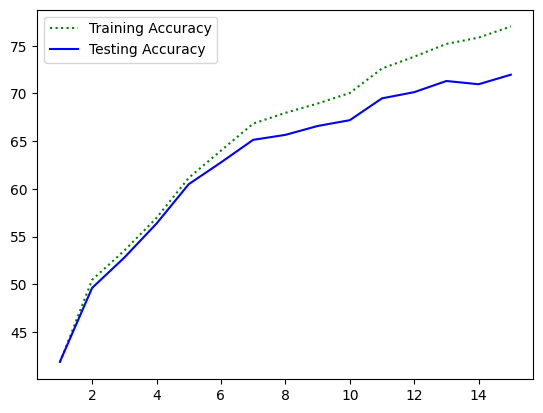

Accuracy for class: plane is 64.8 %
Accuracy for class: car   is 83.6 %
Accuracy for class: bird  is 53.2 %
Accuracy for class: cat   is 57.4 %
Accuracy for class: deer  is 76.0 %
Accuracy for class: dog   is 67.0 %
Accuracy for class: frog  is 77.2 %
Accuracy for class: horse is 75.6 %
Accuracy for class: ship  is 82.0 %
Accuracy for class: truck is 82.9 %


In [ ]:
with torch.cuda.device(0):
  lrate = 0.001
  M = CNNModel(8,15,lrate)
  transform = AugData(True)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)

Learning Rate = 0.0001

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 2.299
 Epoch: 2 loss: 2.267
 Epoch: 3 loss: 2.137
 Epoch: 4 loss: 2.002
 Epoch: 5 loss: 1.902
 Epoch: 6 loss: 1.834
 Epoch: 7 loss: 1.783
 Epoch: 8 loss: 1.731
 Epoch: 9 loss: 1.674
 Epoch: 10 loss: 1.617
 Epoch: 11 loss: 1.568
 Epoch: 12 loss: 1.528
 Epoch: 13 loss: 1.497
 Epoch: 14 loss: 1.469
 Epoch: 15 loss: 1.444
---------(lr = 0.0001 )----------


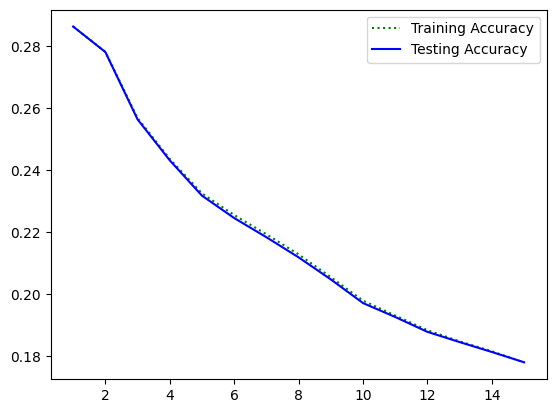

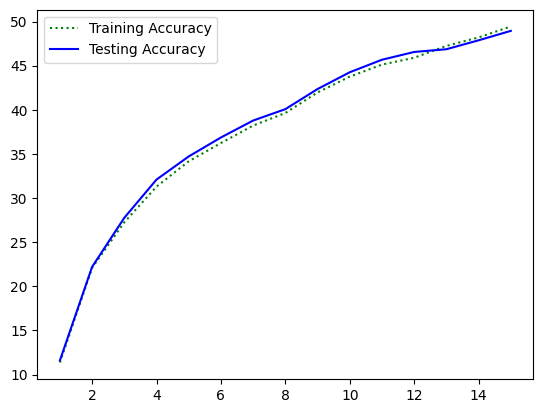

Accuracy for class: plane is 51.8 %
Accuracy for class: car   is 64.6 %
Accuracy for class: bird  is 28.8 %
Accuracy for class: cat   is 28.6 %
Accuracy for class: deer  is 33.2 %
Accuracy for class: dog   is 39.9 %
Accuracy for class: frog  is 66.1 %
Accuracy for class: horse is 57.1 %
Accuracy for class: ship  is 59.7 %
Accuracy for class: truck is 59.6 %


In [ ]:
with torch.cuda.device(0):
  lrate = 0.0001
  M = CNNModel(8,15,lrate)
  transform = AugData(True)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphAcc(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)

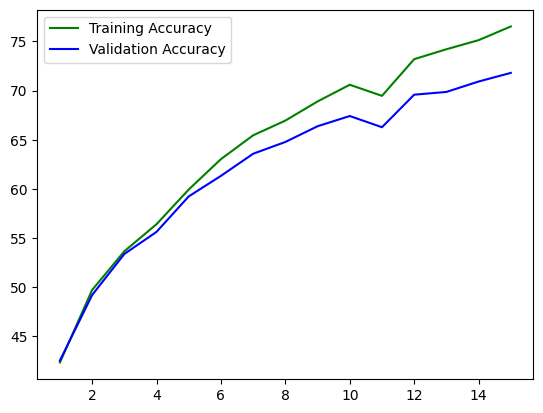

In [ ]:

graphAcc(M.AccTrain,M.AccVal,M.Epoch)

### 3. Number of Training Epochs:
We get better results and accuracy with increasing epochs.
For  Learning Rate  = 0.001 we are getting 71.8 % accuracy in using 15 epochs.


Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.885
 Epoch: 2 loss: 1.478
 Epoch: 3 loss: 1.340
 Epoch: 4 loss: 1.240
 Epoch: 5 loss: 1.145
 Epoch: 6 loss: 1.061
 Epoch: 7 loss: 0.995
 Epoch: 8 loss: 0.941
 Epoch: 9 loss: 0.894
 Epoch: 10 loss: 0.854
 Epoch: 11 loss: 0.816
 Epoch: 12 loss: 0.784
 Epoch: 13 loss: 0.749
 Epoch: 14 loss: 0.718
 Epoch: 15 loss: 0.692
 Epoch: 16 loss: 0.666
 Epoch: 17 loss: 0.639
 Epoch: 18 loss: 0.620
 Epoch: 19 loss: 0.596
 Epoch: 20 loss: 0.575
---------(lr = 0.001 )----------


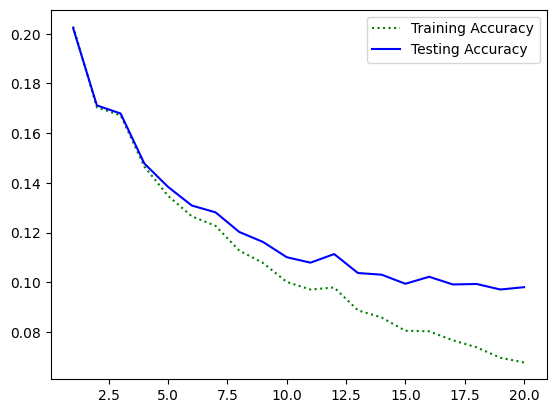

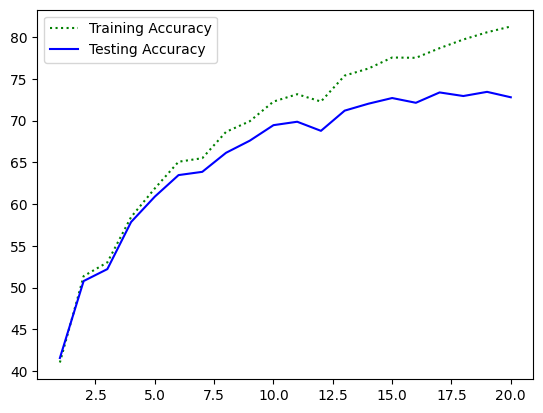

Accuracy for class: plane is 74.7 %
Accuracy for class: car   is 84.8 %
Accuracy for class: bird  is 66.8 %
Accuracy for class: cat   is 55.0 %
Accuracy for class: deer  is 58.1 %
Accuracy for class: dog   is 73.9 %
Accuracy for class: frog  is 78.6 %
Accuracy for class: horse is 75.0 %
Accuracy for class: ship  is 81.1 %
Accuracy for class: truck is 80.0 %


In [ ]:
with torch.cuda.device(0):
  lrate = 0.001
  M = CNNModel(8,20,lrate)
  transform = AugData(True)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)

In [ ]:

  correct_pred = {classname: 0 for classname in M.classes}
  total_pred = {classname: 0 for classname in M.classes}

  # again no gradients needed
  with torch.no_grad():
      for data in M.valLoader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[M.classes[label]] += 1
              total_pred[M.classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 63.2 %
Accuracy for class: car   is 73.2 %
Accuracy for class: bird  is 30.3 %
Accuracy for class: cat   is 37.2 %
Accuracy for class: deer  is 60.2 %
Accuracy for class: dog   is 57.1 %
Accuracy for class: frog  is 75.5 %
Accuracy for class: horse is 55.3 %
Accuracy for class: ship  is 82.9 %
Accuracy for class: truck is 67.5 %


### Variation in LR:

 
 Apart from using a fixed LR, use a learning rate scheduler of your choice
to vary the LR over the epochs. Here is a good starting tutorial on LR schedulers 8 .
You may use any LR value of your choice. Report the training and validation loss curves,
and class-wise accuracy. What are your observations? You may use a suitable number of
epochs and any batch size for this experiment.

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.932
 Epoch: 2 loss: 1.533
 Epoch: 3 loss: 1.374
 Epoch: 4 loss: 1.267
 Epoch: 5 loss: 1.175
 Epoch: 6 loss: 1.095
 Epoch: 7 loss: 1.026
 Epoch: 8 loss: 0.970
 Epoch: 9 loss: 0.920
 Epoch: 10 loss: 0.875
 Epoch: 11 loss: 0.833
 Epoch: 12 loss: 0.796
 Epoch: 13 loss: 0.761
 Epoch: 14 loss: 0.729
 Epoch: 15 loss: 0.699


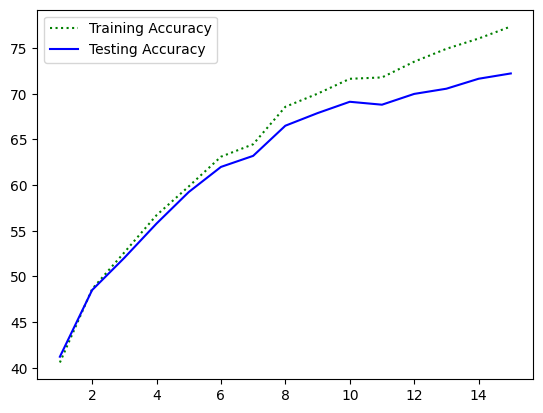

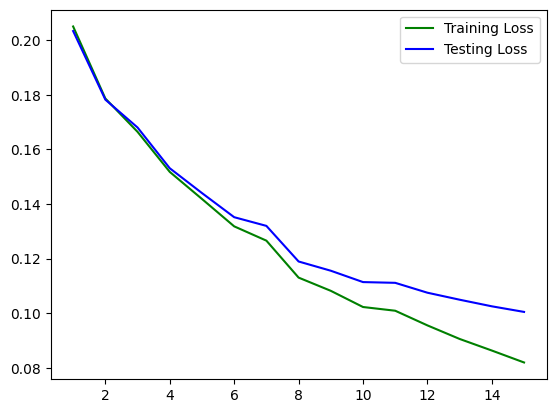

Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 77.6 %
Accuracy for class: bird  is 60.4 %
Accuracy for class: cat   is 57.6 %
Accuracy for class: deer  is 75.5 %
Accuracy for class: dog   is 60.4 %
Accuracy for class: frog  is 81.3 %
Accuracy for class: horse is 68.7 %
Accuracy for class: ship  is 85.7 %
Accuracy for class: truck is 83.4 %


In [ ]:
class CNNModelLR:
  def __init__(self, batch_size,epochs):
    self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    self.batchSize = batch_size
    self.epochs = epochs
    self.trainloader = None
    self.valLoader = None
    self.AccTrain = []
    self.AccVal = []
    self.LossTrain = []
    self.LossTest = []
    self.Epoch = []
    self.Model = None


    self.trainloader = loadtraindata(self.batchSize)
    self.valLoader = loadtestdata(self.batchSize)


  def train(self):
    batches = 50000/self.batchSize
    Train_Acc=[]
    Test_Acc=[]
    Train_Loss=[]
    Test_Loss=[]
    Epochs=[]
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

    optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
    self.learningRate = CosineAnnealingWarmRestarts(optimizer, 
                                        T_0 = 8,# Number of iterations for the first restart
                                        T_mult = 1, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-4) # Minimum learning rate

    for epoch in range(self.epochs):  
      running_loss = 0.0
      for i, data in enumerate(self.trainloader, 0):
          inputs, labels = data
          images = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backpropagation and optimization
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          # if i % 4000 == 3999:    # print every 2000 mini-batches
      print(f' Epoch: {epoch + 1} loss: {running_loss / batches:.3f}')
      running_loss = 0.0
      with torch.no_grad():
        testAcc = Accuracy(self.valLoader,model)
        trainAcc = Accuracy(self.trainloader, model)
        Train_Acc.append(trainAcc)
        Test_Acc.append(testAcc)
        testLoss = Lloss(self.valLoader,model)
        trainLoss = Lloss(self.trainloader, model)
        Train_Loss.append(trainLoss)
        Test_Loss.append(testLoss)
        Epochs.append(epoch+1)
    self.Model = model
    self.AccVal = Test_Acc
    self.AccTrain = Train_Acc
    self.LossTest = Test_Loss
    self.LossTrain = Train_Loss
    self.Epoch = Epochs

with torch.cuda.device(0):
  M = CNNModelLR(8,15)
  M.train() 
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("=====================================")
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  correct_pred = {classname: 0 for classname in M.classes}
  total_pred = {classname: 0 for classname in M.classes}

  # again no gradients needed
  with torch.no_grad():
      for data in M.valLoader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[M.classes[label]] += 1
              total_pred[M.classes[label]] += 1


  # print accuracy for each class
  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

### Batch size
Vary the batch size {4, 8, 16, 32} and plot the batch-size vs. overall validation
accuracy curves. You may use suitable LR and number of epochs for this experiment.

100%|██████████| 170498071/170498071 [00:05<00:00, 28460933.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
 Epoch: 1 loss: 1.764
 Epoch: 2 loss: 1.367
 Epoch: 3 loss: 1.196
 Epoch: 4 loss: 1.064
 Epoch: 5 loss: 0.963
 Epoch: 6 loss: 0.884
 Epoch: 7 loss: 0.823
 Epoch: 8 loss: 0.766
 Epoch: 9 loss: 0.719
 Epoch: 10 loss: 0.674
 Epoch: 11 loss: 0.636
 Epoch: 12 loss: 0.599
 Epoch: 13 loss: 0.568
 Epoch: 14 loss: 0.535
 Epoch: 15 loss: 0.502
---------(lr = 4 )----------


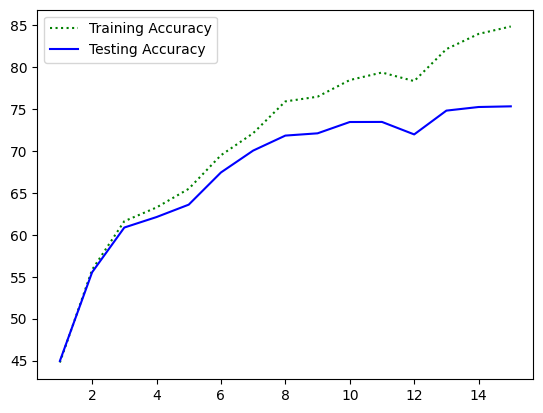

Accuracy for class: plane is 77.3 %
Accuracy for class: car   is 83.8 %
Accuracy for class: bird  is 63.6 %
Accuracy for class: cat   is 63.7 %
Accuracy for class: deer  is 78.5 %
Accuracy for class: dog   is 63.0 %
Accuracy for class: frog  is 80.9 %
Accuracy for class: horse is 73.5 %
Accuracy for class: ship  is 85.3 %
Accuracy for class: truck is 83.7 %
Accuracy = 84.858
Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.938
 Epoch: 2 loss: 1.536
 Epoch: 3 loss: 1.378
 Epoch: 4 loss: 1.277
 Epoch: 5 loss: 1.191
 Epoch: 6 loss: 1.115
 Epoch: 7 loss: 1.044
 Epoch: 8 loss: 0.979
 Epoch: 9 loss: 0.925
 Epoch: 10 loss: 0.879
 Epoch: 11 loss: 0.837
 Epoch: 12 loss: 0.799
 Epoch: 13 loss: 0.763
 Epoch: 14 loss: 0.731
 Epoch: 15 loss: 0.702
---------(lr = 8 )----------


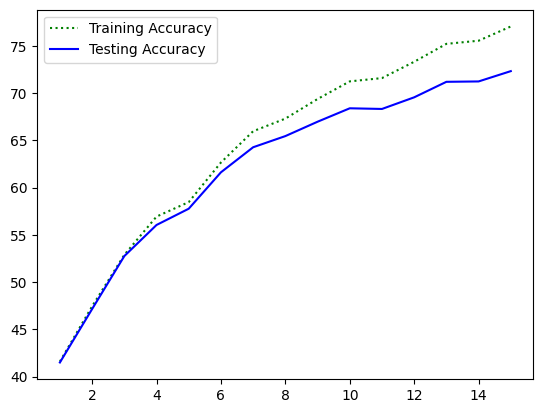

Accuracy for class: plane is 75.1 %
Accuracy for class: car   is 86.7 %
Accuracy for class: bird  is 49.1 %
Accuracy for class: cat   is 46.6 %
Accuracy for class: deer  is 65.7 %
Accuracy for class: dog   is 69.1 %
Accuracy for class: frog  is 83.6 %
Accuracy for class: horse is 78.9 %
Accuracy for class: ship  is 84.1 %
Accuracy for class: truck is 84.2 %
Accuracy = 77.032
Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 2.093
 Epoch: 2 loss: 1.723
 Epoch: 3 loss: 1.561
 Epoch: 4 loss: 1.462
 Epoch: 5 loss: 1.383
 Epoch: 6 loss: 1.325
 Epoch: 7 loss: 1.275
 Epoch: 8 loss: 1.229
 Epoch: 9 loss: 1.184
 Epoch: 10 loss: 1.143
 Epoch: 11 loss: 1.100
 Epoch: 12 loss: 1.064
 Epoch: 13 loss: 1.025
 Epoch: 14 loss: 0.995
 Epoch: 15 loss: 0.964
---------(lr = 16 )----------


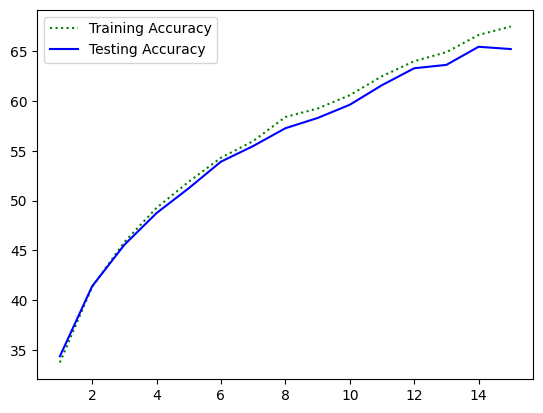

Accuracy for class: plane is 62.1 %
Accuracy for class: car   is 70.2 %
Accuracy for class: bird  is 51.8 %
Accuracy for class: cat   is 42.3 %
Accuracy for class: deer  is 49.9 %
Accuracy for class: dog   is 49.0 %
Accuracy for class: frog  is 84.2 %
Accuracy for class: horse is 75.4 %
Accuracy for class: ship  is 87.4 %
Accuracy for class: truck is 80.0 %
Accuracy = 67.5
Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 2.217
 Epoch: 2 loss: 1.928
 Epoch: 3 loss: 1.783
 Epoch: 4 loss: 1.633
 Epoch: 5 loss: 1.544
 Epoch: 6 loss: 1.483
 Epoch: 7 loss: 1.432
 Epoch: 8 loss: 1.390
 Epoch: 9 loss: 1.353
 Epoch: 10 loss: 1.324
 Epoch: 11 loss: 1.292
 Epoch: 12 loss: 1.262
 Epoch: 13 loss: 1.231
 Epoch: 14 loss: 1.204
 Epoch: 15 loss: 1.177
---------(lr = 32 )----------


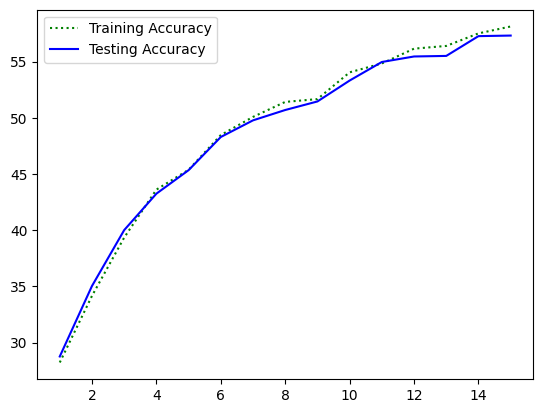

Accuracy for class: plane is 59.6 %
Accuracy for class: car   is 74.0 %
Accuracy for class: bird  is 40.0 %
Accuracy for class: cat   is 47.7 %
Accuracy for class: deer  is 33.3 %
Accuracy for class: dog   is 37.0 %
Accuracy for class: frog  is 85.4 %
Accuracy for class: horse is 52.9 %
Accuracy for class: ship  is 75.3 %
Accuracy for class: truck is 67.9 %
Accuracy = 58.118


In [ ]:

BatchTrain_Acc=[]
BatchTest_Acc=[]
Batch_size = [4,8,16,32]
with torch.cuda.device(0):
  for i in range(4):
    lrate = 0.001
    M = CNNModel(Batch_size[i],15,lrate)
    transform = AugData(True)
    M.train()
    model = M.Model
    trainloader = M.trainloader
    valLoader = M.valLoader
    print("---------("+"lr = "+str(Batch_size[i])+" )----------")
    graphAcc(M.AccTrain,M.AccVal,M.Epoch)
    class_validation(M)
    BatchTrain_Acc.append(M.AccTrain[14])
    BatchTest_Acc.append(M.AccVal[14])
    print("Accuracy = " + str(M.AccTrain[14]))


## Effect of Loss Function

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.979
 Epoch: 2 loss: 1.517
 Epoch: 3 loss: 1.364
 Epoch: 4 loss: 1.268
 Epoch: 5 loss: 1.190
 Epoch: 6 loss: 1.120
 Epoch: 7 loss: 1.056
 Epoch: 8 loss: 0.997
 Epoch: 9 loss: 0.943
 Epoch: 10 loss: 0.894
 Epoch: 11 loss: 0.856
 Epoch: 12 loss: 0.820
 Epoch: 13 loss: 0.786
 Epoch: 14 loss: 0.756
 Epoch: 15 loss: 0.724
---------(lr = 0.001 )----------


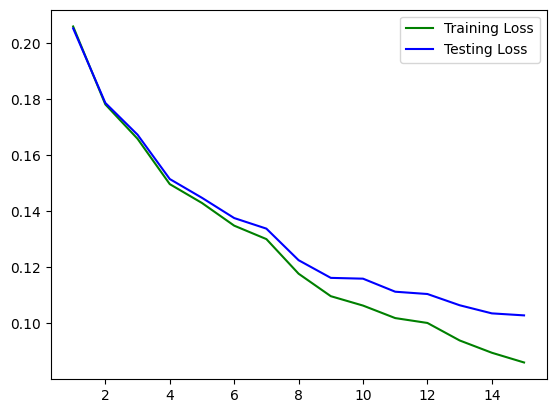

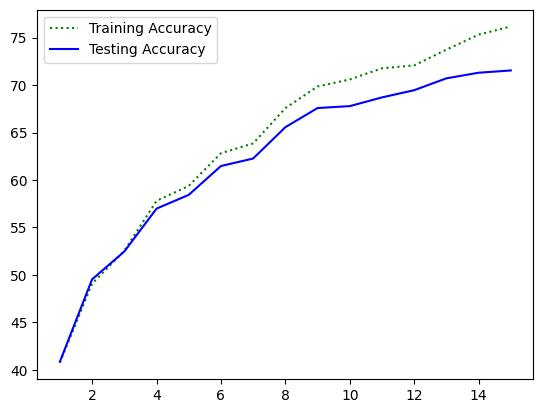

Accuracy for class: plane is 74.1 %
Accuracy for class: car   is 82.2 %
Accuracy for class: bird  is 66.6 %
Accuracy for class: cat   is 50.8 %
Accuracy for class: deer  is 64.4 %
Accuracy for class: dog   is 55.9 %
Accuracy for class: frog  is 85.2 %
Accuracy for class: horse is 74.7 %
Accuracy for class: ship  is 83.0 %
Accuracy for class: truck is 78.5 %


In [ ]:
with torch.cuda.device(0):

  lrate = 0.001
  M = CNNModel(8,15,lrate)
  transform = AugData(True)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)


## Effect of Data Augmentation

Files already downloaded and verified
Files already downloaded and verified
 Epoch: 1 loss: 1.899
 Epoch: 2 loss: 1.477
 Epoch: 3 loss: 1.340
 Epoch: 4 loss: 1.244
 Epoch: 5 loss: 1.164
 Epoch: 6 loss: 1.096
 Epoch: 7 loss: 1.035
 Epoch: 8 loss: 0.974
 Epoch: 9 loss: 0.924
 Epoch: 10 loss: 0.882
 Epoch: 11 loss: 0.843
 Epoch: 12 loss: 0.810
 Epoch: 13 loss: 0.776
 Epoch: 14 loss: 0.744
 Epoch: 15 loss: 0.715
---------(lr = 0.001 )----------


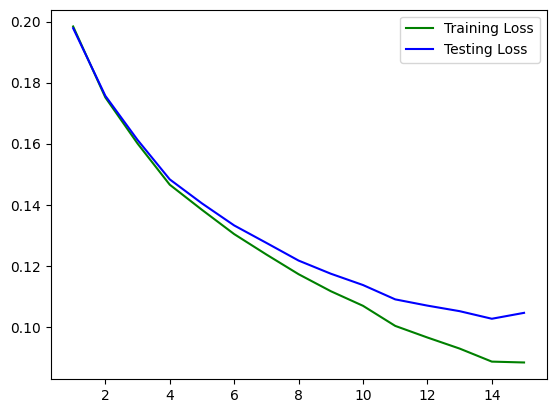

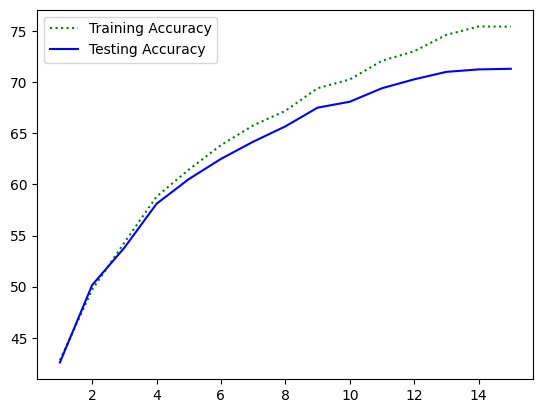

Accuracy for class: plane is 71.6 %
Accuracy for class: car   is 77.9 %
Accuracy for class: bird  is 59.1 %
Accuracy for class: cat   is 54.4 %
Accuracy for class: deer  is 57.9 %
Accuracy for class: dog   is 73.1 %
Accuracy for class: frog  is 74.8 %
Accuracy for class: horse is 82.2 %
Accuracy for class: ship  is 75.8 %
Accuracy for class: truck is 86.2 %


In [ ]:
with torch.cuda.device(0):
  lrate = 0.001
  M = CNNModel(8,15,lrate)
  transform = AugData(False)
  M.train()
  model = M.Model
  trainloader = M.trainloader
  valLoader = M.valLoader
  print("---------("+"lr = "+str(lrate)+" )----------")

  graphLoss(M.LossTrain,M.LossTest,M.Epoch)
  graphAcc(M.AccTrain,M.AccVal,M.Epoch)
  class_validation(M)